In [1]:
import os
import gc
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skimage
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import glob

from PIL import Image
from tqdm import tqdm
import random as rnd
import cv2
from numpy import expand_dims
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

%matplotlib inline

In [2]:

train_main_path = '../data/Cattle-Disease-Classification/v2/'

train_df = pd.DataFrame()

def list_directories_recursively(path='.'):
    # The pattern '**/' will match all directories recursively
    out = []
    for dirname in glob.glob(f"{path}/**/", recursive=True):
        out.append(dirname)
        # yield dirname
    return out


print("All directories recursively from current directory:")
list_directories_recursively(train_main_path)

All directories recursively from current directory:


['../data/Cattle-Disease-Classification/v2/',
 '../data/Cattle-Disease-Classification/v2/lsd/',
 '../data/Cattle-Disease-Classification/v2/lsd/Head/',
 '../data/Cattle-Disease-Classification/v2/lsd/CloseUpSkin/',
 '../data/Cattle-Disease-Classification/v2/lsd/Leg/',
 '../data/Cattle-Disease-Classification/v2/lsd/FullBody/',
 '../data/Cattle-Disease-Classification/v2/lsd/Uncertain/',
 '../data/Cattle-Disease-Classification/v2/lsd/CloseUp Skin/',
 '../data/Cattle-Disease-Classification/v2/fmd/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Mouth Nose/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Tongue/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Teats/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Leg/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Uncertain/',
 '../data/Cattle-Disease-Classification/v2/fmd/FMD/Drooling/',
 '../data/Cattle-Disease-Classification/v2/fmd/Mouth Nose/',
 '../data/Cattl

In [3]:
from pprint import pprint

for one_dir in list_directories_recursively(train_main_path):
    pprint(one_dir)

'../data/Cattle-Disease-Classification/v2/'
'../data/Cattle-Disease-Classification/v2/lsd/'
'../data/Cattle-Disease-Classification/v2/lsd/Head/'
'../data/Cattle-Disease-Classification/v2/lsd/CloseUpSkin/'
'../data/Cattle-Disease-Classification/v2/lsd/Leg/'
'../data/Cattle-Disease-Classification/v2/lsd/FullBody/'
'../data/Cattle-Disease-Classification/v2/lsd/Uncertain/'
'../data/Cattle-Disease-Classification/v2/lsd/CloseUp Skin/'
'../data/Cattle-Disease-Classification/v2/fmd/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Mouth Nose/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Tongue/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Teats/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Leg/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Uncertain/'
'../data/Cattle-Disease-Classification/v2/fmd/FMD/Drooling/'
'../data/Cattle-Disease-Classification/v2/fmd/Mouth Nose/'
'../data/Cattle-Disease-Classification/v2/fmd/Ton

In [7]:
# fmd -
#     - leg
#     - mouth
#     - teats
#     - tongue
#     - drooling
#     - uncertain
# lsd -
#     - skin
#     - body
#     - head
#     - leg
#     - uncertain
# healthy


all_classes = [
    'fmd',
    'lsd',
    'healthy',
]
classes = []
paths = []

position = [
    'leg',
    'mouth',
    'teats',
    'tongue',
    'drooling',
    'uncertain',
    'skin',
    'body',
    'head',
    'leg',
    'uncertain',
    'healthy',
]

sub_dirs = list_directories_recursively(train_main_path)
positions = []
for one_class in all_classes:
    for one_sub in sub_dirs:
        if one_class.lower() in one_sub.lower():
            for one_file in os.listdir(one_sub):
                classes.append(one_class)
                single_file_path = one_sub+one_file
                pos_flag = False
                for one_pos in position:
                    if one_pos.lower() in single_file_path.lower() and not pos_flag:
                        pos_flag = True
                        positions.append(one_pos)
                if not pos_flag:
                    positions.append('uncertain')
                paths.append(single_file_path)

train_df['classname'] = classes
train_df['path'] = paths
train_df['position'] = positions
print(train_df.head())
print(train_df.info())

  classname                                               path   position
0       fmd  ../data/Cattle-Disease-Classification/v2/fmd/R...  uncertain
1       fmd   ../data/Cattle-Disease-Classification/v2/fmd/FMD  uncertain
2       fmd  ../data/Cattle-Disease-Classification/v2/fmd/R...  uncertain
3       fmd  ../data/Cattle-Disease-Classification/v2/fmd/M...      mouth
4       fmd  ../data/Cattle-Disease-Classification/v2/fmd/P...  uncertain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066 entries, 0 to 6065
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   classname  6066 non-null   object
 1   path       6066 non-null   object
 2   position   6066 non-null   object
dtypes: object(3)
memory usage: 142.3+ KB
None


In [9]:
train_df.count()

classname    6066
path         6066
position     6066
dtype: int64

In [10]:
train_df_data = train_df[train_df['path'].str.contains('jpg|png|jpeg',case=False,regex=True)]
train_df_data['path'] = train_df_data['path'].str.replace(train_main_path, '')


/tmp/ipykernel_9928/2043012802.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df_data['path'] = train_df_data['path'].str.replace(train_main_path, '')
/tmp/ipykernel_9928/2043012802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_data['path'] = train_df_data['path'].str.replace(train_main_path, '')


In [11]:
store = []
duplicate = []
for file_names in tqdm(train_df_data['path']):
    r_file_name = file_names.split('/')[-1]
    if r_file_name in store:
        print(file_names)
        train_df_data.drop(train_df_data[train_df_data['path'] == file_names].index, inplace = True)
    else:
        store.append(r_file_name)

  0%|          | 0/5991 [00:00<?, ?it/s]/home/akide/anaconda3/envs/Cattle-Disease-Classification/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 39%|███▊      | 2313/5991 [00:00<00:00, 11680.67it/s]

fmd/Mouth Nose/Beef Cattle 3_Camera_4.JPG
fmd/Mouth Nose/Beef Cattle 3_Camera_17.png
fmd/Mouth Nose/Beef Cattle 10_Camera_13.JPG
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_00_32_32.Still003.jpg
fmd/Mouth Nose/Beef Cattle 7_Camera_18.JPG
fmd/Mouth Nose/Beef Cattle 10_Camera_20.png
fmd/Mouth Nose/Beef Cattle 1_Camera_9.JPG
fmd/Mouth Nose/Beef Cattle 2_Handphone_11.png
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_00_34_28.Still004.jpg
fmd/Mouth Nose/Beef Cattle 8_Handphone_24.JPG
fmd/Mouth Nose/Beef Cattle 9_Camera_15.JPG
fmd/Mouth Nose/Beef Cattle 10_Camera_12.JPG
fmd/Mouth Nose/Beef Cattle 1_Camera_11.JPG
fmd/Mouth Nose/Beef Cattle 7_Handphone_3.jpg
fmd/Mouth Nose/Beef Cattle 3_Camera_6.JPG
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_01_05_45.Still008.jpg
fmd/Mouth Nose/Beef Cattle 3_Camera_13.JPG
fmd/Mouth Nose/Beef Cattle 3_Camera_16.png
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_01_08_44.Still009.jpg
fmd/Mouth Nose/Beef Cattle 4_Handphone_9.JPG
fmd/Mouth Nose/Beef Cattle 4_Handphone_11.JPG
fmd/

 58%|█████▊    | 3482/5991 [00:00<00:00, 11359.87it/s]

healthy/Healthy Animal/Cow - diff angles/front/00000223.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000271.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000069.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000261.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000258.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000193.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000113.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000008.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000137.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000079.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000062.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000168.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000051.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000270.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000140.jpg
healthy/Healthy Animal/Cow - diff angles/front/00000073.jpg
healthy/Healthy Animal/Cow - diff angles

100%|██████████| 5991/5991 [00:00<00:00, 13705.28it/s]

healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_8.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_35.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_6.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_34.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_15.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_19.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_37.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_5.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_20.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_25.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_3.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_41.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_16.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_13.jpeg
healthy/Cattle/Beef Cattle/Head/Beef Cattle_Healthy_Head_1.jpeg
healthy/Cattle/Beef Cattle/Hea

In [12]:
train_df_data.count()

classname    5200
path         5200
position     5200
dtype: int64

In [13]:
train_df_data.describe()


,classname,path,position
count,5200,5200,5200
unique,3,5200,10
top,healthy,fmd/FMD/Mouth Nose/Beef Cattle 3_Camera_4.JPG,healthy
freq,3546,1,3355


healthy    3546
lsd         929
fmd         725
Name: classname, dtype: int64


<AxesSubplot: >

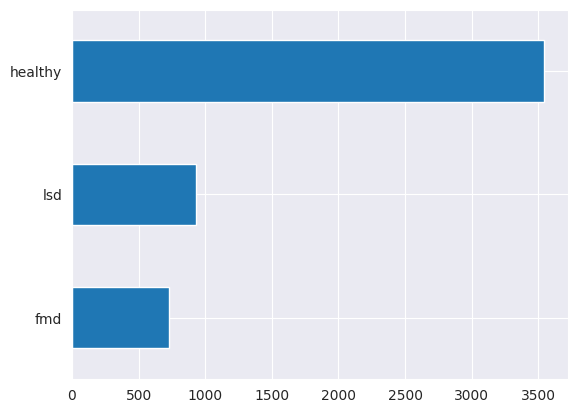

In [14]:
print(train_df_data.classname.value_counts())
train_df_data.classname.value_counts().sort_values().plot(kind = 'barh')

In [15]:

for i,one_name in enumerate(all_classes):
    train_df_data.loc[train_df_data[train_df_data['classname'] == one_name].index,"label"] = i

train_df_data['label'].astype(int)

train_df_data.label.unique()

/home/akide/anaconda3/envs/Cattle-Disease-Classification/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/akide/anaconda3/envs/Cattle-Disease-Classification/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array([0., 1., 2.])

In [18]:

for i,one_pos in enumerate(position):
    train_df_data.loc[train_df_data[train_df_data['position'] == one_pos].index,"position"] = i

train_df_data['position'].astype(int)

train_df_data.position.unique()

/home/akide/anaconda3/envs/Cattle-Disease-Classification/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array([1, 3, 2, 0, 5, 4, 8, 6, 7, 11], dtype=object)

In [19]:
train_df_data

,classname,path,position,label
15,fmd,fmd/FMD/Mouth Nose/Beef Cattle 3_Camera_4.JPG,1,0.0
16,fmd,fmd/FMD/Mouth Nose/Beef Cattle 16_Handphone_13...,1,0.0
17,fmd,fmd/FMD/Mouth Nose/Beef Cattle 12_Camera_6.JPG,1,0.0
18,fmd,fmd/FMD/Mouth Nose/Beef Cattle 3_Camera_17.png,1,0.0
19,fmd,fmd/FMD/Mouth Nose/Beef Cattle 13_Camera_1.JPG,1,0.0
...,...,...,...,...
5864,healthy,healthy/Healthy Animal/Sheep Breeds - Faceimag...,11,2.0
5865,healthy,healthy/Healthy Animal/Sheep Breeds - Faceimag...,11,2.0
5866,healthy,healthy/Healthy Animal/Sheep Breeds - Faceimag...,11,2.0
5867,healthy,healthy/Healthy Animal/Sheep Breeds - Faceimag...,11,2.0


In [20]:
train_df_data.to_csv('v_3_out.csv',index=False)


In [13]:
def is_cv2_readable(file_path):
    try:
        img = cv2.imread(file_path)
        if img is not None:
            return True
        else:
            return False
    except Exception as e:
        return False
    
for file_names in tqdm(train_df_data['path']):
    if is_cv2_readable(train_main_path+file_names) == False:
        print(file_names)

  1%|          | 31/5991 [00:03<10:16,  9.67it/s]


KeyboardInterrupt: 

In [16]:
train_df_data['path']

15          fmd/FMD/Mouth Nose/Beef Cattle 3_Camera_4.JPG
16      fmd/FMD/Mouth Nose/Beef Cattle 16_Handphone_13...
17         fmd/FMD/Mouth Nose/Beef Cattle 12_Camera_6.JPG
18         fmd/FMD/Mouth Nose/Beef Cattle 3_Camera_17.png
19         fmd/FMD/Mouth Nose/Beef Cattle 13_Camera_1.JPG
                              ...                        
6062    healthy/Cattle/Beef Cattle/Full Body/Beef Catt...
6063    healthy/Cattle/Beef Cattle/Full Body/Beef Catt...
6064    healthy/Cattle/Beef Cattle/Full Body/Beef Catt...
6065    healthy/Cattle/Beef Cattle/Full Body/Beef Catt...
6066    healthy/Cattle/Beef Cattle/Full Body/Beef Catt...
Name: path, Length: 5991, dtype: object

In [21]:
save_path = '/home/akide/dataset/Cattle-Disease-Classification/v2_resized/'

# Ensure the save directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Iterate through each file name
for file_name in tqdm(train_df_data['path']):
    full_path = os.path.join(train_main_path, file_name)
    
    dir_name = '/'.join(file_name.split('/')[:-1])
    dir_name= os.path.join(save_path, dir_name)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    # If image is not readable by cv2, print its name
    if not is_cv2_readable(full_path):
        print(file_name)
        continue

    # Read and resize the image
    image = cv2.imread(full_path)
    target_size = (384, 384)  # Desired dimensions (width, height)
    resized_image = cv2.resize(image, target_size)

    # Save the resized image
    cv2.imwrite(os.path.join(save_path, file_name), resized_image)

 33%|███▎      | 1978/5991 [06:45<02:36, 25.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 38%|███▊      | 2248/5991 [06:49<00:45, 82.37it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
100%|██████████| 5991/5991 [07:13<00:00, 13.81it/s] 


In [19]:
os.path.join(save_path, file_name)

'/home/akide/dataset/Cattle-Disease-Classification/v2_resized/fmd/FMD/Mouth Nose/Beef Cattle 12_Handphone_Video BC12 2.00_00_04_56.Still003.jpg'

In [20]:
dir_name

'fmd/FMD/Mouth Nose'

In [15]:
store = []
for file_names in tqdm(train_df_data['path']):
    r_file_name = file_names.split('/')[-1]
    if r_file_name in store:
        print(file_names)
    else:
        store.append(r_file_name)

100%|██████████| 5991/5991 [00:00<00:00, 91631.72it/s]

fmd/Mouth Nose/Beef Cattle 3_Camera_4.JPG
fmd/Mouth Nose/Beef Cattle 3_Camera_17.png
fmd/Mouth Nose/Beef Cattle 10_Camera_13.JPG
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_00_32_32.Still003.jpg
fmd/Mouth Nose/Beef Cattle 7_Camera_18.JPG
fmd/Mouth Nose/Beef Cattle 10_Camera_20.png
fmd/Mouth Nose/Beef Cattle 1_Camera_9.JPG
fmd/Mouth Nose/Beef Cattle 2_Handphone_11.png
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_00_34_28.Still004.jpg
fmd/Mouth Nose/Beef Cattle 8_Handphone_24.JPG
fmd/Mouth Nose/Beef Cattle 9_Camera_15.JPG
fmd/Mouth Nose/Beef Cattle 10_Camera_12.JPG
fmd/Mouth Nose/Beef Cattle 1_Camera_11.JPG
fmd/Mouth Nose/Beef Cattle 7_Handphone_3.jpg
fmd/Mouth Nose/Beef Cattle 3_Camera_6.JPG
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_01_05_45.Still008.jpg
fmd/Mouth Nose/Beef Cattle 3_Camera_13.JPG
fmd/Mouth Nose/Beef Cattle 3_Camera_16.png
fmd/Mouth Nose/Camera_Video BC4 2.MOV.00_01_08_44.Still009.jpg
fmd/Mouth Nose/Beef Cattle 4_Handphone_9.JPG
fmd/Mouth Nose/Beef Cattle 4_Handphone_11.JPG
fmd/